In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

sns.set_theme(style="whitegrid")

project_root = ".." 
results_dir = os.path.join(project_root, "results")
validation_csv_path = os.path.join(results_dir, "features_validation_set.csv")

print(f"Loading data from: {validation_csv_path}")
df_val = pd.read_csv(validation_csv_path)
print("Validation data loaded successfully!")
print(f"Shape of the dataset: {df_val.shape}")

# Core GCS categories.
# Filter out the noisy data to get a clear picture of the baseline separation.
# Simplified 'gcs_class' column.
def get_gcs_class(category):
    if category == 'gcs_2':
        return 'GCS 2 (Incomprehensible)'
    elif category == 'gcs_3':
        return 'GCS 3 (Word Salad)'
    elif category == 'gcs_45_clean':
        return 'GCS 4/5 (Coherent)'
    else:
        return 'Other (Noisy)' 

df_val['gcs_class'] = df_val['category'].apply(get_gcs_class)
df_clean = df_val[df_val['gcs_class'] != 'Other (Noisy)'].copy()

print("\nValue counts for clean GCS classes:")
print(df_clean['gcs_class'].value_counts())

display(df_clean.head())

Loading data from: ../results/features_validation_set.csv
Validation data loaded successfully!
Shape of the dataset: (2177, 11)

Value counts for clean GCS classes:
gcs_class
GCS 3 (Word Salad)          371
GCS 4/5 (Coherent)          264
GCS 2 (Incomprehensible)    115
Name: count, dtype: int64


,filepath,category,snr,start_time,end_time,transcription,avg_logprob,lexical_validity,perplexity,silero_speech_prob,whisper_no_speech_prob,gcs_class
0,/home/marlow/Documents/GCS_Speech_Thesis/data/...,gcs_2,NaN,0.000,0.864,Ja.,-1.221640,1.0,3.881850,0.406820,0.402092,GCS 2 (Incomprehensible)
1,/home/marlow/Documents/GCS_Speech_Thesis/data/...,gcs_2,NaN,0.288,0.512,Danke.,-1.300596,1.0,2.153446,0.730938,0.294451,GCS 2 (Incomprehensible)
2,/home/marlow/Documents/GCS_Speech_Thesis/data/...,gcs_2,NaN,0.704,0.960,der,-1.813070,1.0,NaN,0.889062,0.403387,GCS 2 (Incomprehensible)
3,/home/marlow/Documents/GCS_Speech_Thesis/data/...,gcs_2,NaN,1.248,1.632,Aber...,-1.198252,1.0,121.199234,0.681825,0.250842,GCS 2 (Incomprehensible)
4,/home/marlow/Documents/GCS_Speech_Thesis/data/...,gcs_2,NaN,1.664,1.952,Danke.,-0.959292,1.0,2.153446,0.802021,0.256680,GCS 2 (Incomprehensible)


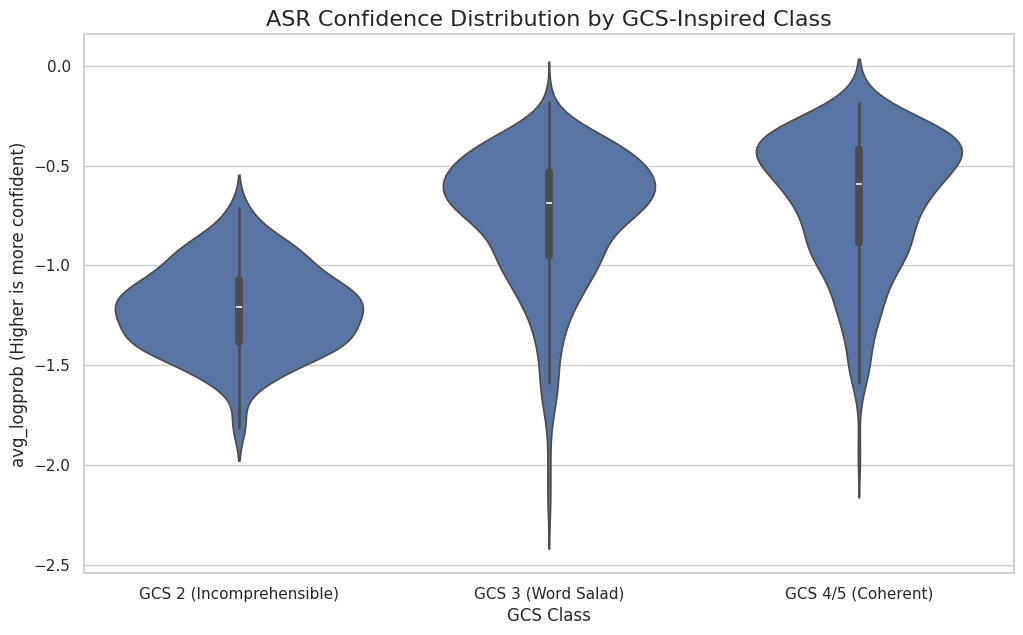

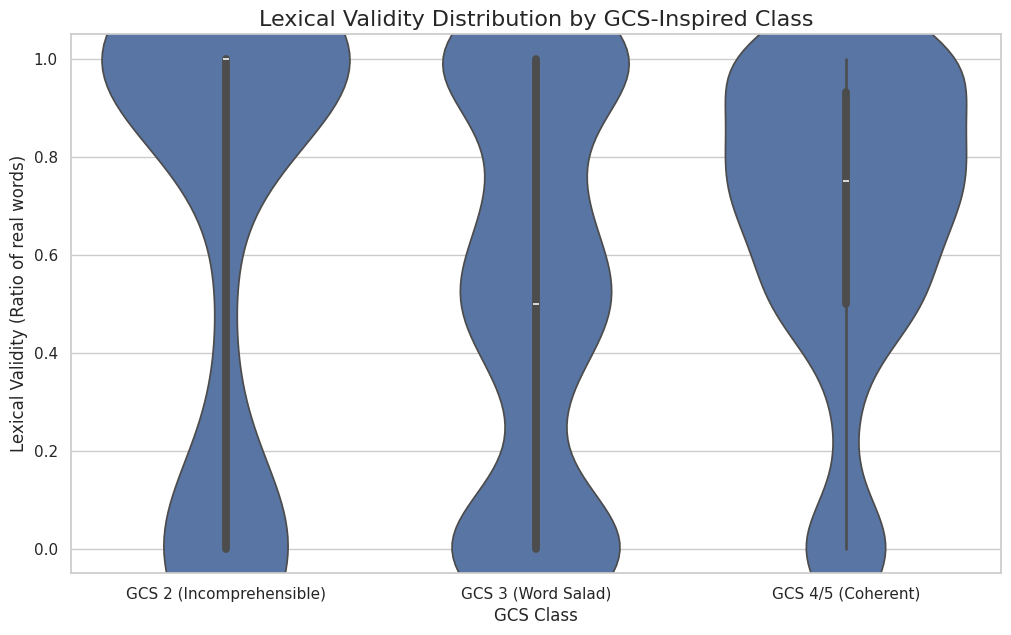

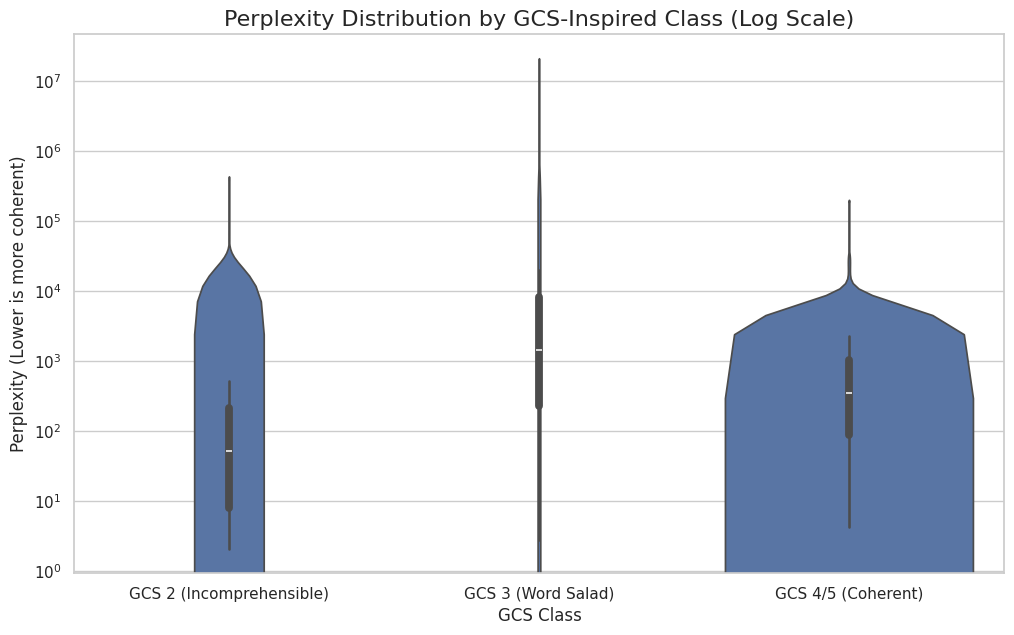

In [2]:
# --- RQ2: Visualize Individual Feature Effectiveness ---

class_order = ['GCS 2 (Incomprehensible)', 'GCS 3 (Word Salad)', 'GCS 4/5 (Coherent)']

# --- Plot 1: ASR Confidence (avg_logprob) ---
plt.figure(figsize=(12, 7))
sns.violinplot(x='gcs_class', y='avg_logprob', data=df_clean, order=class_order)
plt.title('ASR Confidence Distribution by GCS-Inspired Class', fontsize=16)
plt.xlabel('GCS Class', fontsize=12)
plt.ylabel('avg_logprob (Higher is more confident)', fontsize=12)
plt.show()

# --- Plot 2: Lexical Validity ---
plt.figure(figsize=(12, 7))
sns.violinplot(x='gcs_class', y='lexical_validity', data=df_clean, order=class_order)
plt.title('Lexical Validity Distribution by GCS-Inspired Class', fontsize=16)
plt.xlabel('GCS Class', fontsize=12)
plt.ylabel('Lexical Validity (Ratio of real words)', fontsize=12)
plt.ylim(-0.05, 1.05)
plt.show()

# --- Plot 3: Perplexity (Log Scale) ---
plt.figure(figsize=(12, 7))
sns.violinplot(x='gcs_class', y='perplexity', data=df_clean, order=class_order)
plt.yscale('log')
plt.title('Perplexity Distribution by GCS-Inspired Class (Log Scale)', fontsize=16)
plt.xlabel('GCS Class', fontsize=12)
plt.ylabel('Perplexity (Lower is more coherent)', fontsize=12)
plt.show()

--- Classifier Performance on Validation Set (RULE-BASED) ---
Parameters used: Lex_GCS2=0.5, Conf_GCS2=0.45, PPL_GCS45=0.75, Conf_GCS45=0.55

Classification Report:
              precision    recall  f1-score   support

       GCS 2       0.36      0.95      0.52       115
       GCS 3       0.75      0.20      0.31       371
     GCS 4/5       0.51      0.67      0.58       264

    accuracy                           0.48       750
   macro avg       0.54      0.61      0.47       750
weighted avg       0.61      0.48      0.44       750


Overall Accuracy: 48.00%

Confusion Matrix:


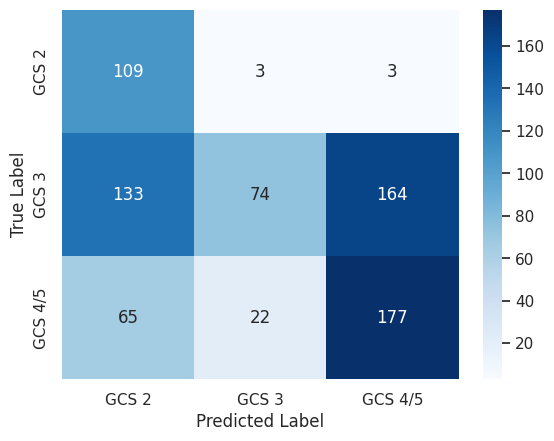

In [3]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

project_root = ".." 
sys.path.append(os.path.join(project_root, 'src'))

# Import the necessary function 
from classifier import normalize_feature

# --- Ensure the df_clean DataFrame exists from the previous cell -.- ---
if 'df_clean' not in locals():
    print("ERROR: Please run the previous cell to load and prepare the 'df_clean' DataFrame first!")
else:
    # --- Step 1: Define Normalization and Rule Parameters ---
    CONFIDENCE_MIN = -2.0
    CONFIDENCE_MAX = -0.1
    PERPLEXITY_MIN = 10.0
    PERPLEXITY_MAX = 10000.0 # Increase max perplexity slightly for better normalization of word salad

    # For short utterances (1-2 words), the decision is based on confidence
    CONFIDENCE_THRESHOLD_SHORT_UTTERANCE = 0.6 
    
    # --- Define the thresholds outside the function ---
    # These are the parameters that will be tuned
    LEXICAL_THRESHOLD_FOR_GCS2 = 0.5 
    CONFIDENCE_THRESHOLD_FOR_GCS2 = 0.45 # Was 0.3, started at 0.4
    PERPLEXITY_THRESHOLD_FOR_GCS45 = 0.75
    CONFIDENCE_THRESHOLD_FOR_GCS45 = 0.55 

    # --- The new rule-based classifier function (Iteration 9 - Certainty-First Tree) ---
    def classify_gcs_level_rule_based(normalized_features, no_speech_prob, raw_features):
            if no_speech_prob > 0.8: return 1
    
            # Ensure transcription is a string before splitting
            transcription_text = str(raw_features.get('transcription', ''))
            num_words = len(transcription_text.split())
    
            # --- Rule 1: Handle very short utterances (1 or 2 words) ---
            if num_words <= 2:
                if normalized_features['norm_confidence'] > CONFIDENCE_THRESHOLD_SHORT_UTTERANCE:
                    return 5 # It's a confident, short, coherent answer like "Ja" or "Danke schön".
                else:
                    return 2 # It's a low-confidence hallucination from a moan or grunt.
    
            # --- Rule 2: Handle longer utterances (3+ words) ---
            
            # Is it an invalid or incomprehensible utterance? (GCS 2 Gate)
            if normalized_features['norm_lexical'] < LEXICAL_THRESHOLD_FOR_GCS2 or \
               normalized_features['norm_confidence'] < CONFIDENCE_THRESHOLD_FOR_GCS2:
                return 2
                
            # If it's valid, is it coherent speech? (GCS 4/5 Gate)
            if normalized_features['norm_inv_perplexity'] > PERPLEXITY_THRESHOLD_FOR_GCS45 and \
               normalized_features['norm_confidence'] > CONFIDENCE_THRESHOLD_FOR_GCS45:
                return 5
                
            # If it's valid but not coherent, it must be word salad (GCS 3)
            return 3
    
    # --- Step 2: Apply the new classifier logic ---
    predictions = []

    for index, row in df_clean.iterrows():
        # Normalize features for each row
        norm_conf = normalize_feature(row['avg_logprob'], CONFIDENCE_MIN, CONFIDENCE_MAX)
        norm_lex = np.clip(row['lexical_validity'], 0.0, 1.0)
        norm_inv_ppl = normalize_feature(row['perplexity'], PERPLEXITY_MIN, PERPLEXITY_MAX, invert=True)
        
        normalized_features = {
            'norm_confidence': norm_conf,
            'norm_lexical': norm_lex,
            'norm_inv_perplexity': norm_inv_ppl
        }
        
        # Pass the raw transcription for the word count rule
        raw_features = {'transcription': row['transcription']}
        
        no_speech_prob = row.get('whisper_no_speech_prob', 0)
        predicted_level = classify_gcs_level_rule_based(normalized_features, no_speech_prob, raw_features)
        predictions.append(predicted_level)
    
    # Add predictions to DataFrame
    df_clean['predicted_gcs_level'] = predictions

    # --- Step 3: Evaluate the performance ---
    def map_true_class_to_numeric(gcs_class_str):
        if gcs_class_str == 'GCS 2 (Incomprehensible)': return 2
        if gcs_class_str == 'GCS 3 (Word Salad)': return 3
        if gcs_class_str == 'GCS 4/5 (Coherent)': return 5
        return 0

    df_clean['true_gcs_level'] = df_clean['gcs_class'].apply(map_true_class_to_numeric)
    true_labels = df_clean['true_gcs_level']
    predicted_labels = df_clean['predicted_gcs_level']

    report_labels = [2, 3, 5]
    report_target_names = ['GCS 2', 'GCS 3', 'GCS 4/5']

    print("--- Classifier Performance on Validation Set (RULE-BASED) ---")
    print(f"Parameters used: Lex_GCS2={LEXICAL_THRESHOLD_FOR_GCS2}, Conf_GCS2={CONFIDENCE_THRESHOLD_FOR_GCS2}, "
          f"PPL_GCS45={PERPLEXITY_THRESHOLD_FOR_GCS45}, Conf_GCS45={CONFIDENCE_THRESHOLD_FOR_GCS45}\n")

    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels, 
                                labels=report_labels, 
                                target_names=report_target_names,
                                zero_division=0))

    print(f"\nOverall Accuracy: {accuracy_score(true_labels, predicted_labels):.2%}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_labels, predicted_labels, labels=[2, 3, 5])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=report_target_names,
                yticklabels=report_target_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()